In [156]:
from skimage import io
import scipy.interpolate
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
from scipy.signal import find_peaks
from scipy.optimize import nnls
dtype = torch.float32

## Set Up Variables and Helper Functions

In [157]:
start_wave = 790
end_wave = 860
num_waves = 161
bandwidth = end_wave-start_wave
waves = torch.linspace(start_wave,end_wave,num_waves)
depth = torch.linspace(0,1/(end_wave-start_wave)*(num_waves-1),num_waves)
window = torch.tensor(np.hanning(len(waves)))
# recon_window = torch.ones_like(window)
recon_window = window + .01

res = .44 * (((end_wave-start_wave)/2+start_wave)*1e-9)**2/((end_wave-start_wave)*1e-9)
zmax = .25 * (((end_wave-start_wave)/2+start_wave)*1e-9)**2/(((end_wave-start_wave)*1e-9)/num_waves)
print(res, zmax)

def moving_average(a, n=10) :
    # This only works for even n currently. Should be easy fix but too lazy rn
    filtered = torch.zeros_like(a)
    ret = torch.cumsum(a, 0)
    ret[n:] = ret[n:] - ret[:-n]
    filtered[int(n/2)-1:-int(n/2)] = ret[n - 1:] / n
    filtered[0:int(n/2)-1] = filtered[int(n/2)-1]
    filtered[-int(n/2):] = filtered[-int(n/2)-1]
    return filtered

def dc_estimate(waves, signal, width):
    peaks, _ = find_peaks(signal, height=-10)
    valleys, _ = find_peaks(-signal, height=-10)
    length = np.min((len(peaks),len(valleys)))
    x = np.zeros(length+2)
    mid = np.zeros(length+2)
    for ii in range(length):
        if np.min(valleys)<np.min(peaks):
            x[ii+1] = (waves[valleys[ii]] - waves[peaks[ii]])/2 + waves[peaks[ii]]
            mid[ii+1] = (signal[peaks[ii]]-signal[valleys[ii]])/2 + signal[valleys[ii]]
        else:
            x[ii+1] = (-waves[valleys[ii]] + waves[peaks[ii]])/2 + waves[valleys[ii]]
            mid[ii+1] = (signal[peaks[ii]]-signal[valleys[ii]])/2 + signal[valleys[ii]]
    x[0] = waves[0]
    mid[0] = signal[0]
    x[-1] = waves[-1]
    mid[-1] = signal[-1]
    plt.figure(figsize = (15,10))
    plt.plot(waves[peaks],signal[peaks],'x')
    plt.plot(waves[valleys],signal[valleys],'x')
    plt.plot(waves,signal)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title('DC Estimation')
    plt.plot(x,mid)
    smoothed = moving_average(torch.tensor(mid), width)
    interp = scipy.interpolate.interp1d(x, smoothed,'cubic')
    interp_dc = torch.tensor(interp(waves),dtype = dtype)
    return interp_dc

4.278214285714286e-06 0.000391359375


## Load PSF Data

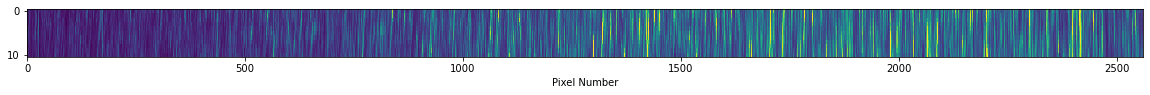

In [221]:
im = io.imread('600p220grit_doubleRot4deg_25ms_80mm_8bit.tif')
%matplotlib inline
A = im[:,int(im.shape[1]/2),:]
A = torch.tensor(A, dtype = dtype).T

fig, ax = plt.subplots(figsize=(20,20))

ax.imshow(A.T, interpolation='none')#, extent=[0,A.shape[0],waves[-1],waves[0]])
ax.set_aspect(10) #
plt.xlabel('Pixel Number')
# plt.ylabel('Wavelength (nm)')
plt.show()

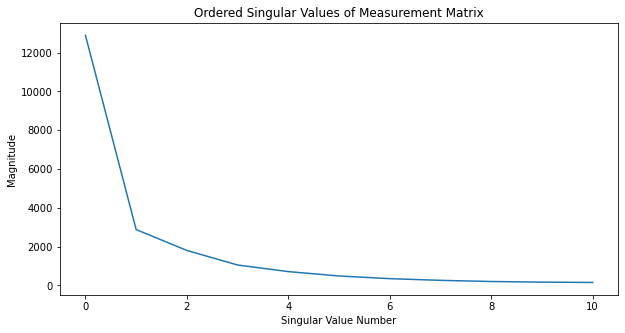

The numerical rank is 11 for a level of .005*sigma_max
The condition number is 86.243286


In [220]:
svs = np.linalg.svd(A)[1]
plt.figure(figsize = (10,5))
plt.plot(svs)
plt.title('Ordered Singular Values of Measurement Matrix')
plt.xlabel('Singular Value Number')
plt.ylabel('Magnitude')
plt.show()
print("The numerical rank is " + str(np.sum(svs>(svs[0]*.005))) + ' for a level of .005*sigma_max')
print("The condition number is " + str(svs[0]/svs[-1]))

## Load Measurement Data

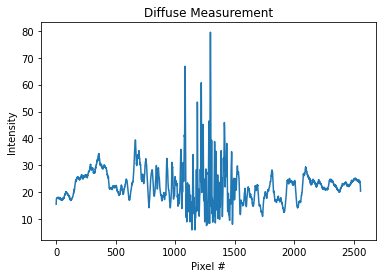

In [173]:
meas = io.imread('depthPos_#0004_8bit.tif')
meas = torch.tensor(meas[:,int(meas.shape[1]/2),:],dtype = dtype)
meas = torch.mean(meas,0)

plt.figure()
plt.plot(meas)
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.title('Diffuse Measurement')
plt.show()

## Load and Process Ground Truth

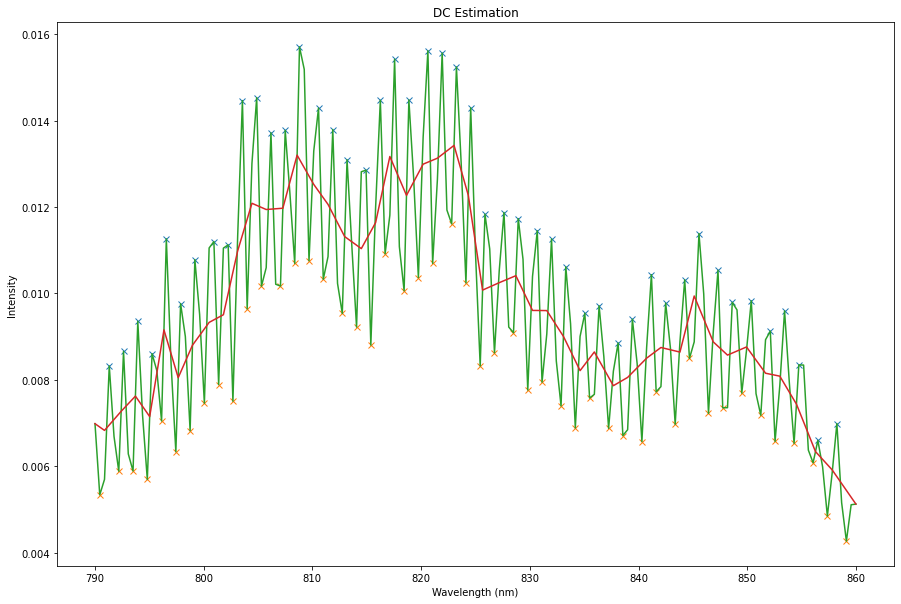

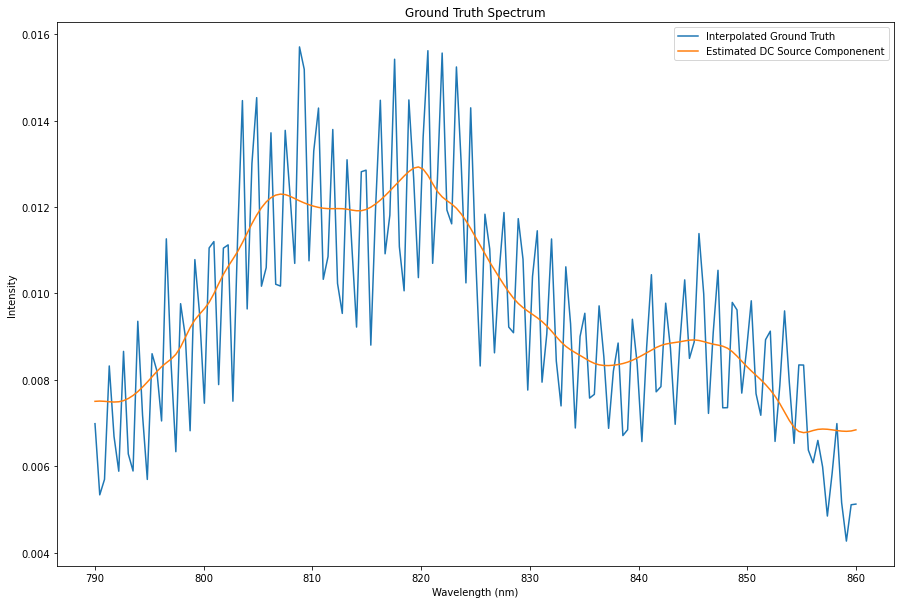

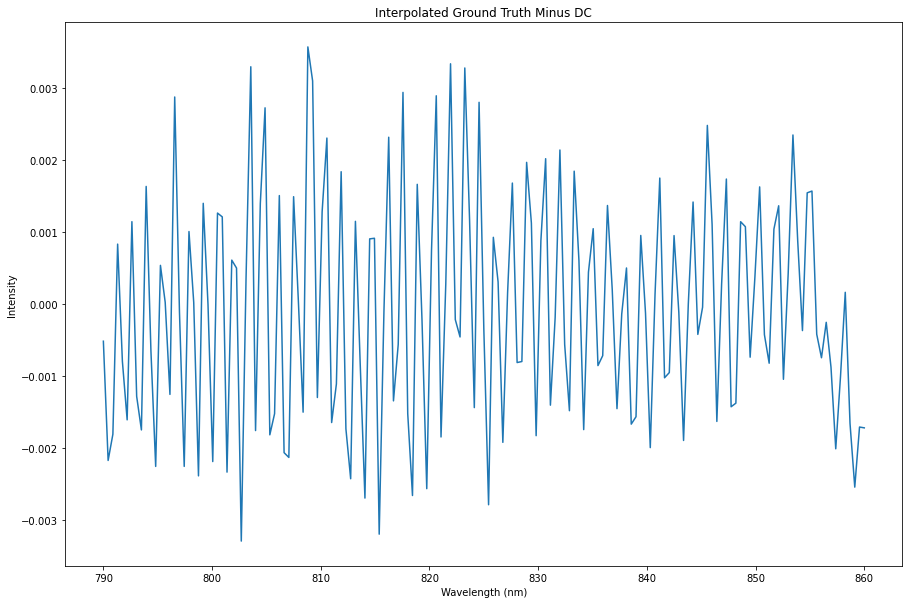

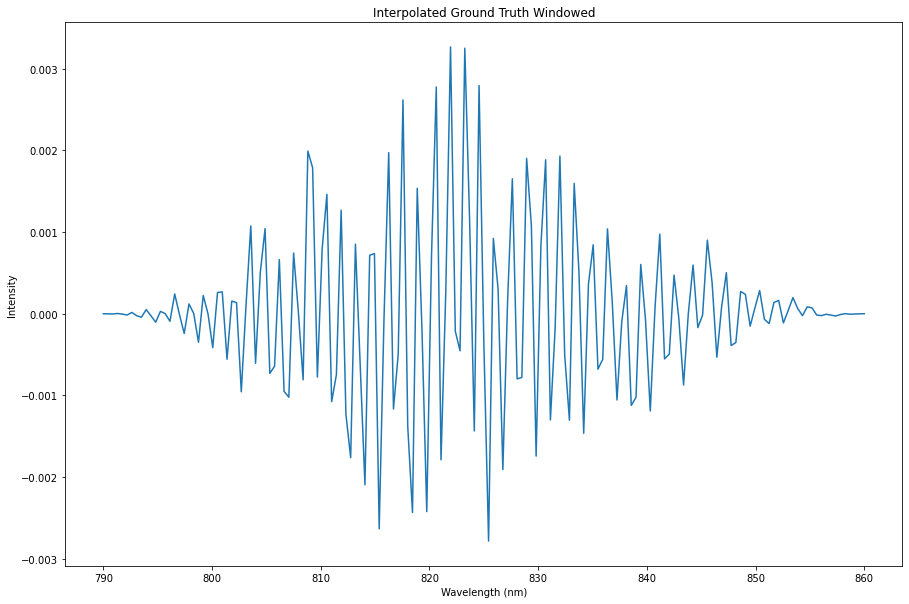

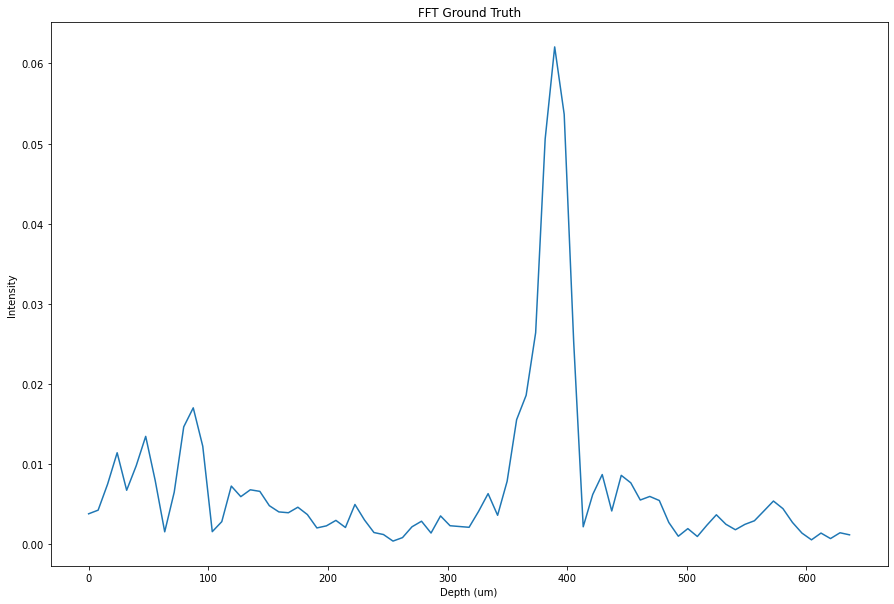

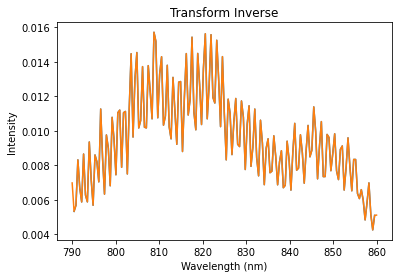

In [209]:
%matplotlib inline
gt = scipy.io.loadmat('GroundTruth/400umGT.mat')['ans']
start = np.argmin(abs(gt[:,0]-(start_wave-1)))
end = np.argmin(abs(gt[:,0]-(end_wave+1)))
gt_waves = torch.tensor(gt[start:end,0])
gt_intensity = torch.tensor(gt[start:end,1])

# Resample GT to Calibration Wavelengths
interp = scipy.interpolate.interp1d(gt_waves,gt_intensity,'cubic')
interp_gt = torch.tensor(interp(waves),dtype = dtype)
scaling_factor = torch.max(torch.matmul(A,interp_gt))/torch.max(meas)
interp_gt = interp_gt/scaling_factor

# Calculate and display DC signal
interp_dc = dc_estimate(waves, interp_gt, 6)

# Display Interpolated Ground Truth
plt.figure(figsize =(15,10))
plt.plot(waves, interp_gt)
plt.plot(waves, interp_dc)
plt.legend(['Interpolated Ground Truth', 'Estimated DC Source Componenent'])
plt.title('Ground Truth Spectrum')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display DC Corrected Spectrum
interp_gt_corrected = interp_gt-interp_dc
plt.figure(figsize =(15,10))
plt.plot(waves, interp_gt_corrected)
plt.title('Interpolated Ground Truth Minus DC')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display windowed spectrum
interp_gt_windowed = interp_gt_corrected * window
plt.figure(figsize = (15,10))
plt.plot(waves, interp_gt_windowed)
plt.title('Interpolated Ground Truth Windowed')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display FFT
interp_gt_fft = torch.fft.fftn(interp_gt_windowed)
recon = torch.fft.fftshift(interp_gt_fft).abs()[int(len(interp_gt)/2):]
space = 8*torch.linspace(0,(len(waves)/2)-1,len(recon))
plt.figure(figsize = (15,10))
plt.plot(space,recon)
plt.title('FFT Ground Truth')
plt.ylabel('Intensity')
# plt.xticks([])
plt.xlabel('Depth (um)')
plt.show()

# Display Inversion
inv = torch.fft.ifftn(interp_gt_fft).real/window + interp_dc
plt.figure()
plt.plot(waves, inv)
plt.plot(waves, interp_gt)
plt.title('Transform Inverse')
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Need a better DC estimate
# Maybe try a different domain for sparsity

## Adjoint Check

In [210]:
x = torch.randn_like(waves)
y = torch.randn_like(meas)
print(torch.dot(torch.matmul(A,x),y))
print(torch.dot(x,torch.matmul(A.T,y)))

tensor(-1731.4131)
tensor(-1731.4126)


# Least Squares Reconstruction

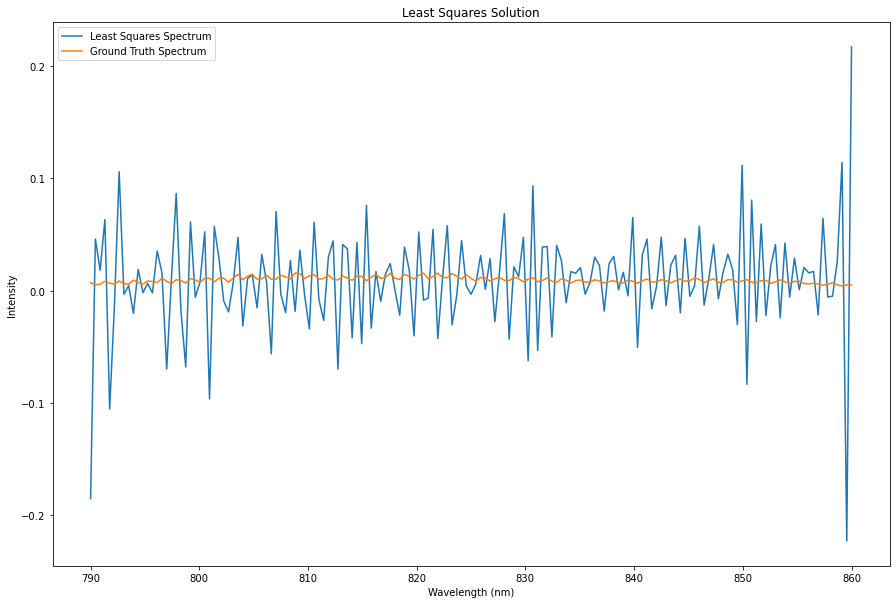

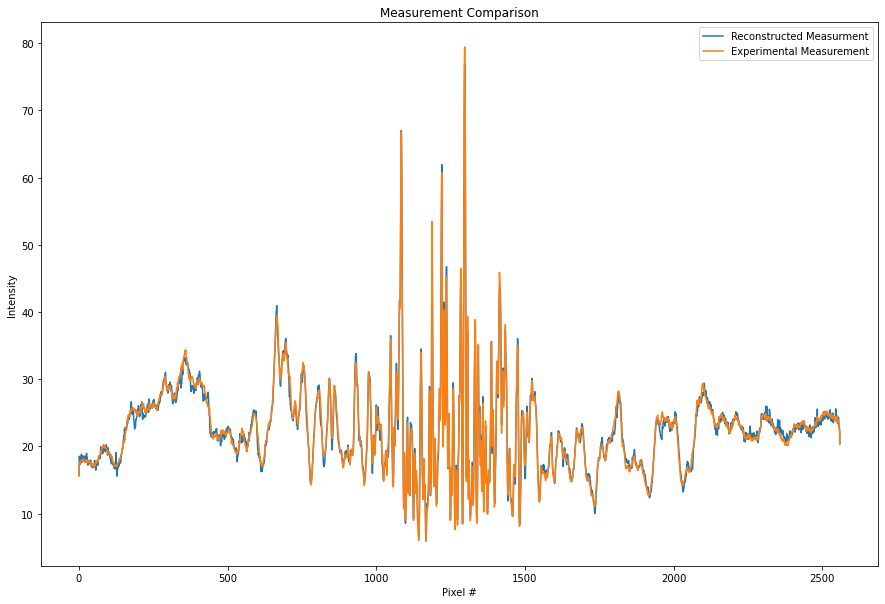

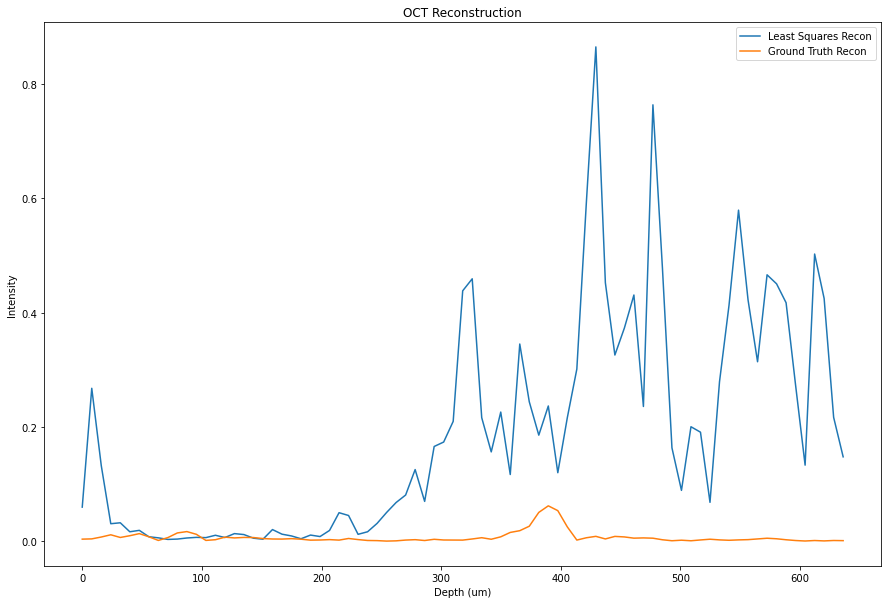

In [211]:
AtA = torch.matmul(A.T,A)
reg = torch.diag(torch.ones(AtA.shape[1])*0)

ls_sol = torch.matmul(torch.inverse(AtA+reg),torch.matmul(A.T, meas))
plt.figure(figsize = (15,10))
plt.plot(waves, ls_sol)
plt.plot(waves, interp_gt)
plt.title('Least Squares Solution')
plt.legend(['Least Squares Spectrum','Ground Truth Spectrum'])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(torch.matmul(A,ls_sol))
# plt.plot(torch.matmul(A,interp_gt))
plt.plot(meas)
plt.title('Measurement Comparison')
plt.legend(['Reconstructed Measurment', 'Experimental Measurement'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.show()

ls_oct = torch.fft.fftshift(torch.fft.fftn((ls_sol-interp_dc)*window)).abs()[int(len(interp_gt)/2):]
plt.figure(figsize = (15,10))
plt.plot(space, ls_oct)
plt.plot(space, recon)
plt.xlabel('Depth (um)')
plt.legend(['Least Squares Recon','Ground Truth Recon'])
plt.title('OCT Reconstruction')
plt.ylabel('Intensity')
plt.show()

The new condition number is 11.47750749190013


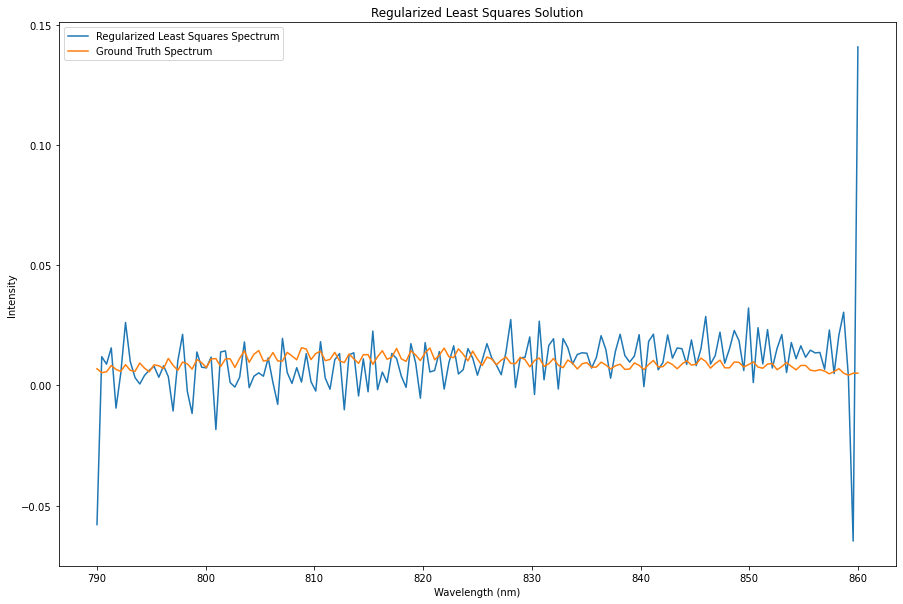

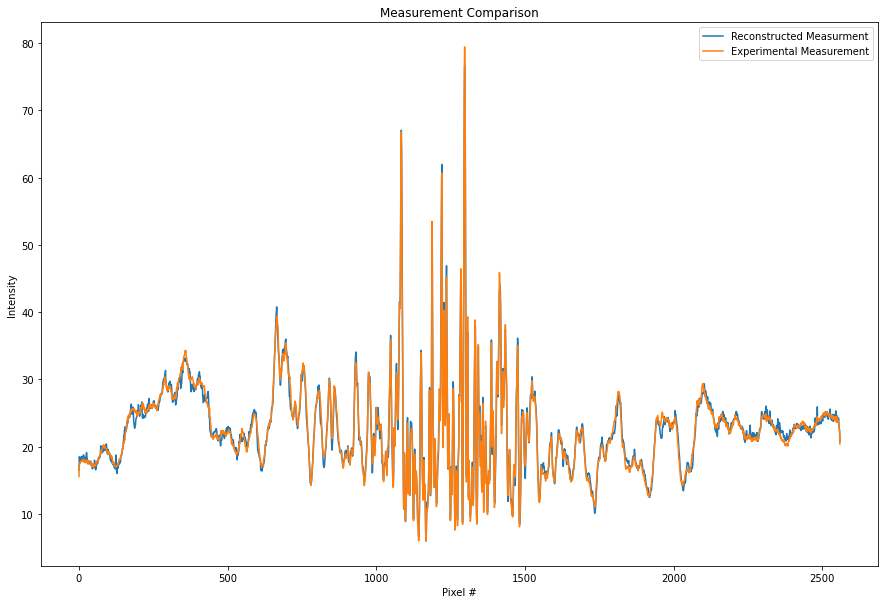

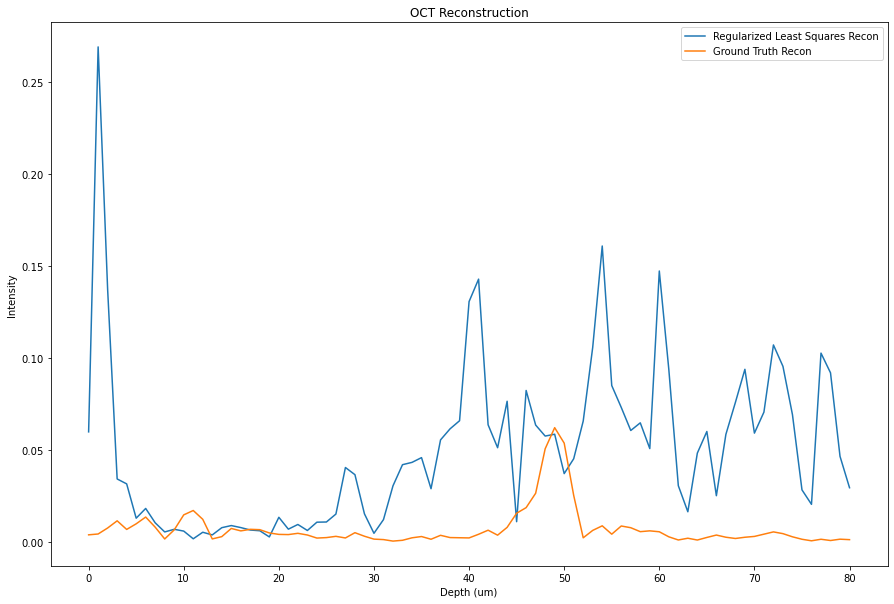

In [212]:
lam = 1000
print('The new condition number is ' + str((svs[0]+lam)/(svs[-1]+lam)))

AtA = torch.matmul(A.T,A)
reg = torch.diag(torch.ones(AtA.shape[1])*lam)

ls_sol = torch.matmul(torch.inverse(AtA+reg),torch.matmul(A.T, meas))
plt.figure(figsize = (15,10))
plt.plot(waves, ls_sol)
plt.plot(waves, interp_gt)
plt.title('Regularized Least Squares Solution')
plt.legend(['Regularized Least Squares Spectrum','Ground Truth Spectrum'])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(torch.matmul(A,ls_sol))
# plt.plot(torch.matmul(A,interp_gt))
plt.plot(meas)
plt.title('Measurement Comparison')
plt.legend(['Reconstructed Measurment', 'Experimental Measurement'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.show()

ls_oct = torch.fft.fftshift(torch.fft.fftn((ls_sol-interp_dc)*window)).abs()[int(len(interp_gt)/2):]
plt.figure(figsize = (15,10))
plt.plot(ls_oct)
plt.plot(recon)
plt.legend(['Regularized Least Squares Recon','Ground Truth Recon'])
plt.title('OCT Reconstruction')
plt.ylabel('Intensity')
plt.xlabel('Depth (um)')
plt.show()

# Non-Negative Least Squares Solve

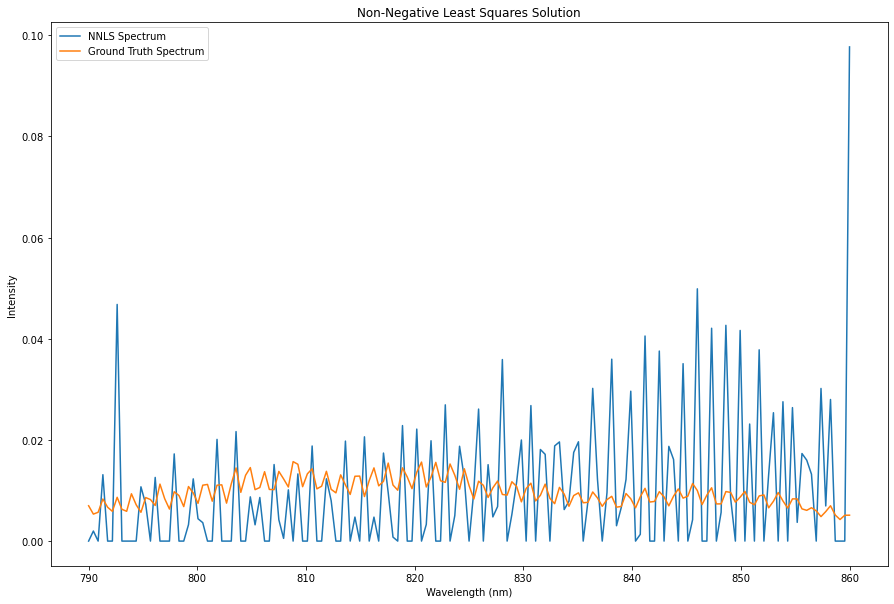

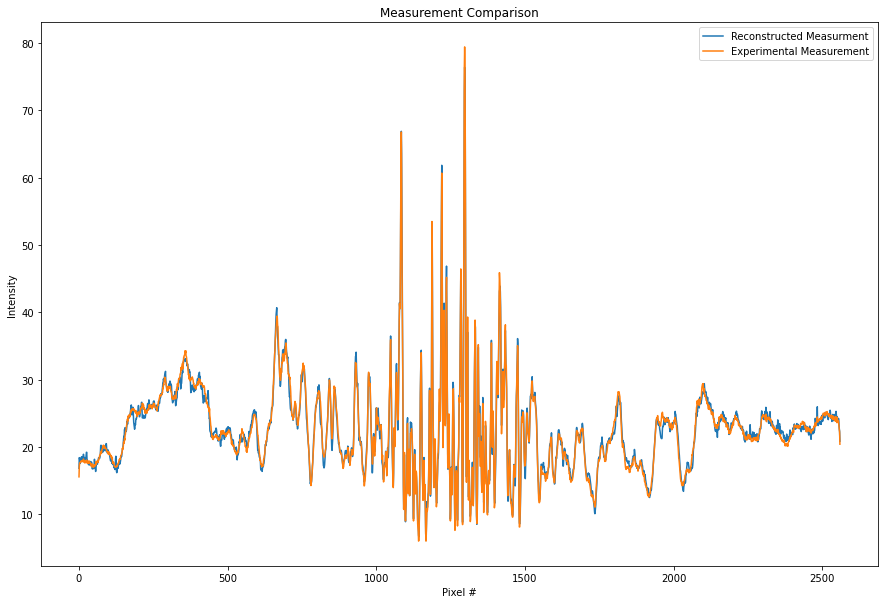

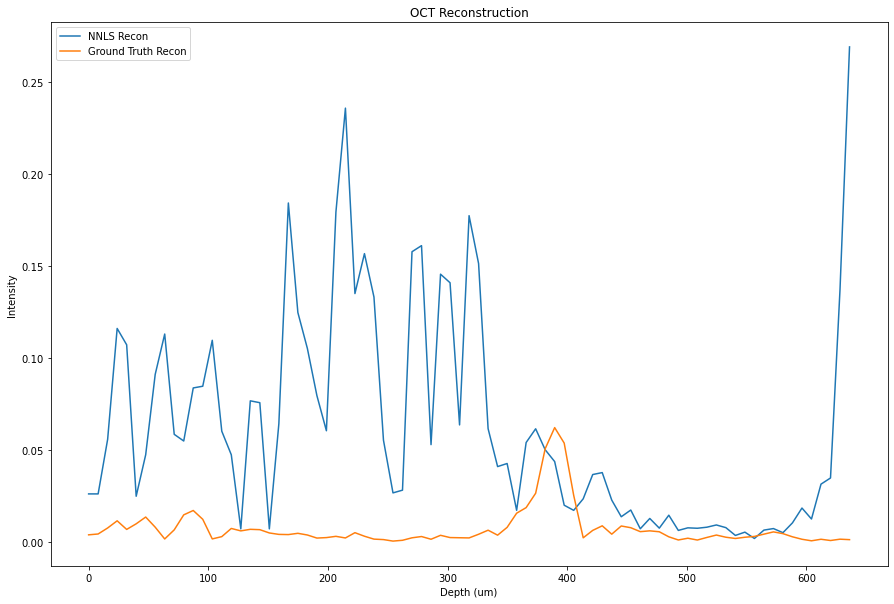

In [213]:
from scipy.optimize import nnls
test = nnls(A,meas)[0]
plt.figure(figsize = (15,10))
plt.plot(waves, test)
plt.plot(waves, interp_gt)
plt.title('Non-Negative Least Squares Solution')

plt.legend(['NNLS Spectrum','Ground Truth Spectrum'])
plt.xlabel('Wavelength (nm)')
plt.ylabel('Intensity')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(torch.matmul(A,torch.tensor(test,dtype = dtype)))
# plt.plot(torch.matmul(A,interp_gt))
plt.plot(meas)
plt.title('Measurement Comparison')
plt.legend(['Reconstructed Measurment', 'Experimental Measurement'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.show()

plt.figure(figsize = (15,10))
plt.plot(space, torch.fft.fftn((torch.tensor(test)-interp_dc)*window).abs()[int(len(interp_gt)/2):])
plt.plot(space, recon)
plt.legend(['NNLS Recon','Ground Truth Recon'])
plt.title('OCT Reconstruction')
plt.ylabel('Intensity')
plt.xlabel('Depth (um)')
plt.show()

## Define Functions for Proximal Operator

In [214]:
def sparse_transform(signal, dc):
    return torch.fft.fftn((signal-dc))

def inv_sparse_transform(signal, dc):
    return (torch.fft.ifftn(signal).real+dc).type(dtype)

# def complex_soft_thr(signal, gamma):
#     imag = signal.imag
#     real = signal.real
#     return torch.sign(real)*torch.clamp(torch.abs(real)-gamma,min=0) + imag*1j

def complex_soft_thr(signal, gamma):
    imag = signal.imag
    real = signal.real
    return signal*((signal.abs()-gamma)>0)

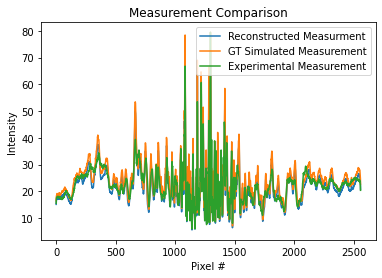

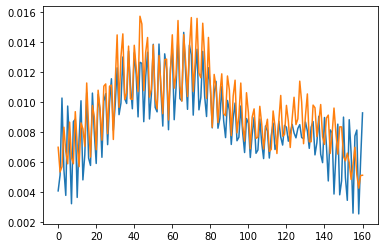

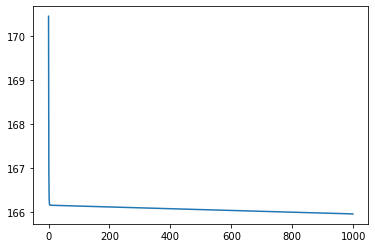

In [215]:
recon = torch.zeros_like(waves, dtype = dtype)
step_size = 3e-9
iters = 1000
lam = 1e-15
gams = torch.logspace(.0001,1,100)
pinv = torch.pinverse(A,lam)



loss = []
recon = torch.matmul(pinv,meas)
recon = torch.zeros_like(recon)
recon = interp_gt
for ii in range(iters):
    residual = torch.matmul(A,recon)-meas
    calc_g = 2*torch.matmul(A.T,residual)
    z = recon - step_size*calc_g
#     b = torch.matmul(pinv,meas) + lam * recon
#     z = torch.matmul(pinv,torch.matmul(A,b))
    dc = interp_dc
    recon = inv_sparse_transform(complex_soft_thr(sparse_transform(z,dc),.05),interp_dc)
    loss.append(torch.norm(torch.matmul(A,recon)-meas))

plt.figure()
plt.plot(torch.matmul(A,recon))
plt.plot(torch.matmul(A,interp_gt))
plt.plot(meas)
plt.title('Measurement Comparison')
plt.legend(['Reconstructed Measurment', 'GT Simulated Measurement', 'Experimental Measurement'])
plt.xlabel('Pixel #')
plt.ylabel('Intensity')
plt.show()

plt.figure()
plt.plot(recon)
plt.plot(interp_gt)
plt.show()

plt.figure()
plt.plot(loss)
plt.show()


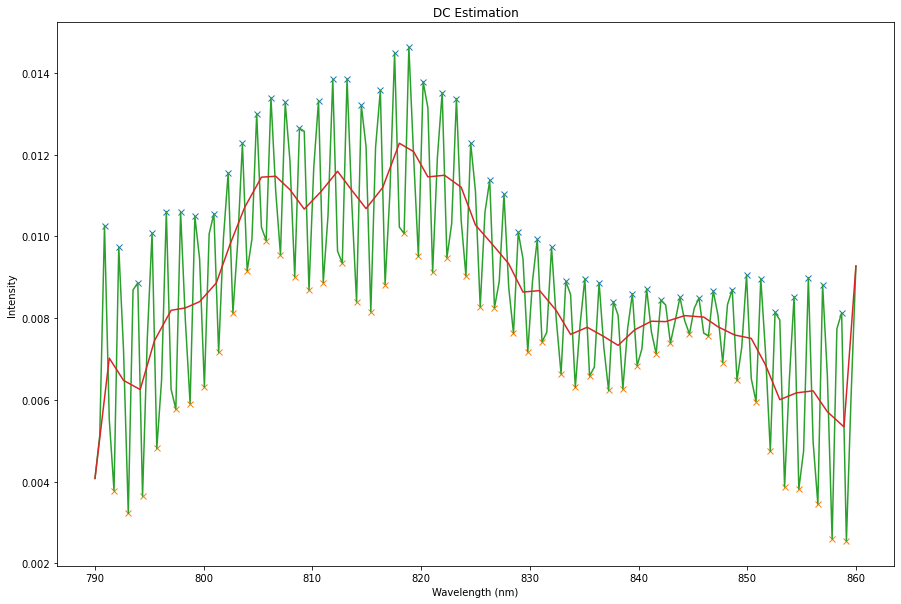

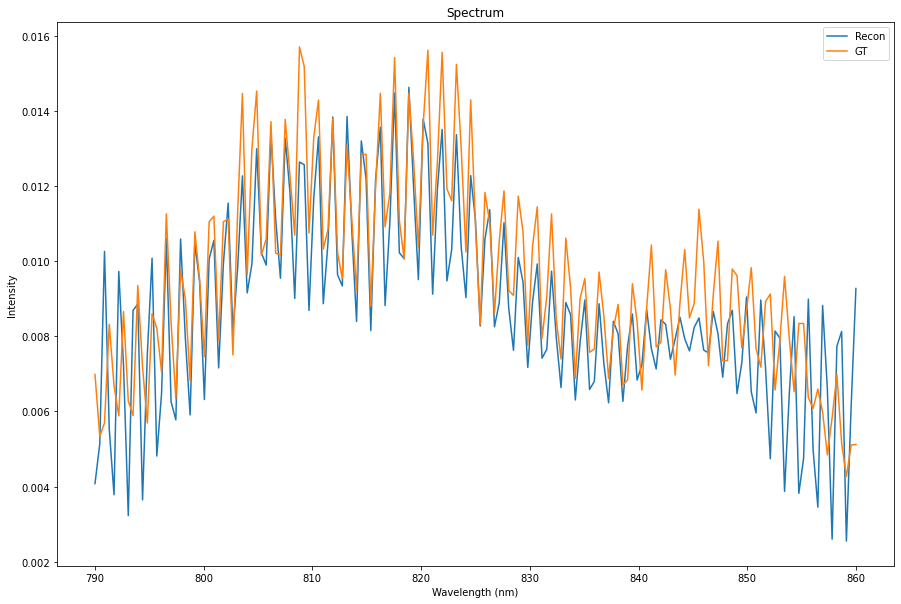

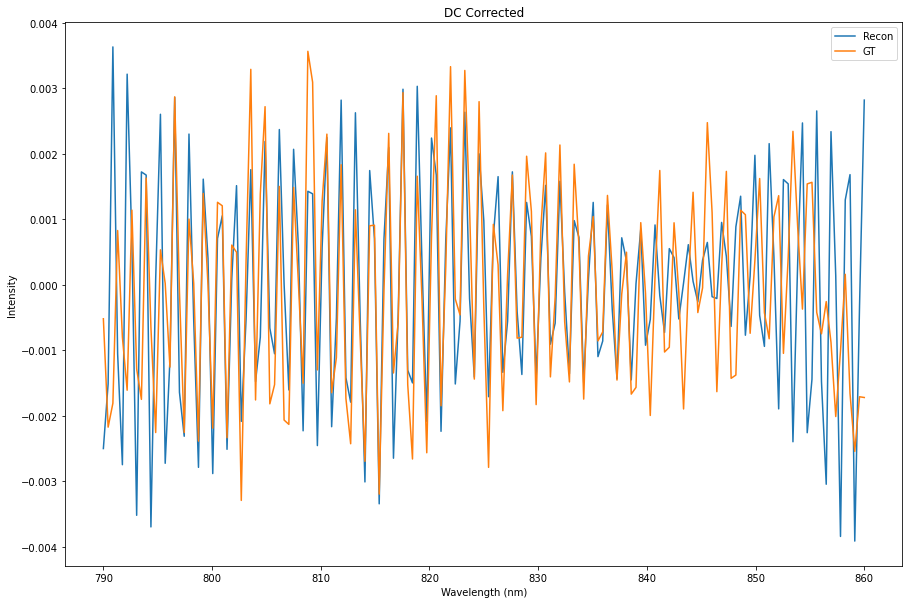

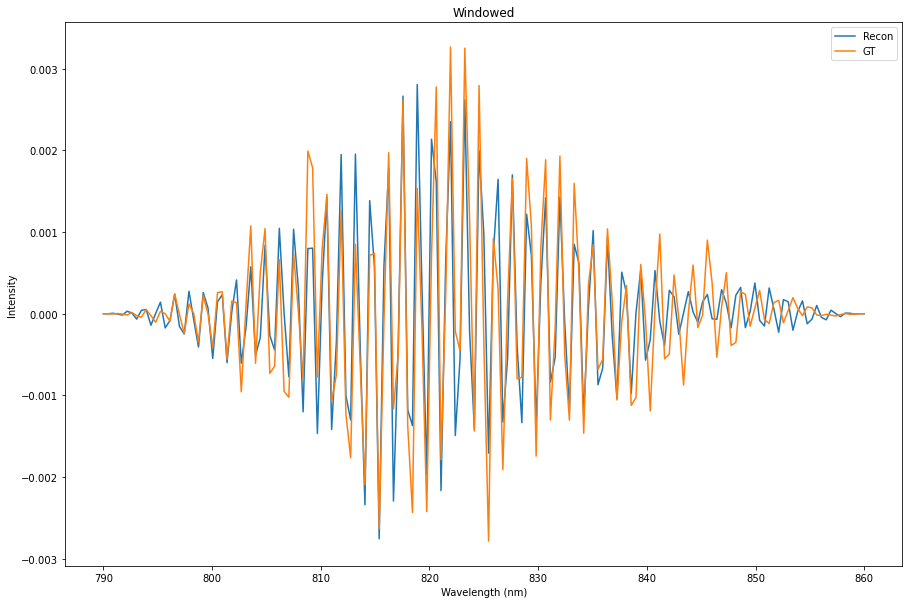

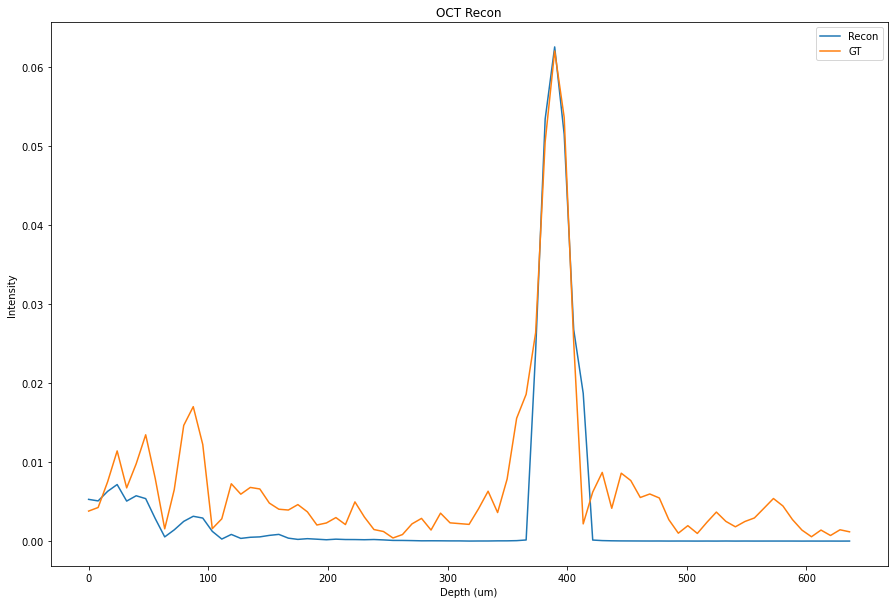

In [216]:
# Calculate and display DC signal
recon_dc = dc_estimate(waves, recon, 6)

# Display Interpolated Ground Truth
plt.figure(figsize = (15,10))
plt.plot(waves, recon)
plt.plot(waves, interp_gt)
plt.title('Spectrum')
plt.legend(['Recon','GT'])
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display DC Corrected Spectrum
recon_corrected = recon-recon_dc
plt.figure(figsize = (15,10))
plt.plot(waves, recon_corrected)
plt.plot(waves, interp_gt_corrected)
plt.legend(['Recon','GT'])
plt.title('DC Corrected')
plt.ylabel('Intensity')

plt.xlabel('Wavelength (nm)')
plt.show()

# Display windowed spectrum
window = torch.tensor(np.hanning(len(waves)))
recon_windowed = recon_corrected * window
plt.figure(figsize = (15,10))
plt.plot(waves, recon_windowed)
plt.plot(waves, interp_gt_windowed)
plt.title('Windowed')
plt.legend(['Recon','GT'])
plt.ylabel('Intensity')
plt.xlabel('Wavelength (nm)')
plt.show()

# Display FFT
recon_fft = torch.fft.fftn(recon_windowed)
plt.figure(figsize = (15,10))
plt.plot(space, torch.fft.fftshift(recon_fft).abs()[int(len(interp_gt)/2):])
plt.plot(space, torch.fft.fftshift(interp_gt_fft).abs()[int(len(interp_gt)/2):])
plt.legend(['Recon','GT'])
plt.title('OCT Recon')
plt.ylabel('Intensity')
plt.xlabel('Depth (um)')
plt.show()